# GHCN Analysis

In [2]:
import os
from glob import glob

import dask
import dask.bag as db
import dask.dataframe as dd

import pandas as pd

from distributed import Client
from dask_jobqueue import SLURMCluster

from IPython.display import display
import matplotlib.pyplot as plt

from ghcn import load_daily

/ext3/miniconda3/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
LOCAL = False


        
if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(
                           # Memory and core limits should be sufficient here
                           memory='16GB', cores=2,

                           # Ensure that Dask uses the correct version of Python on the cluster
                           python='/scratch/work/public/dask/{}/bin/python'.format(dask.__version__),                           
                           
                           # Place the output logs in an accessible location
                           # job_extra=['--export=NONE --output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])]
                           job_extra=['--output=/scratch/{}/all/slurm-%j.out --export=NONE'.format(os.environ['SLURM_JOB_USER'])]
    )

    cluster.submit_command = 'slurm'
#     cluster.worker_memory = '8GB'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)


display(client)

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.32.35.26:8787/status,
Dashboard: http://10.32.35.26:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.32.35.26:41043,Workers: 0
Dashboard: http://10.32.35.26:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
with open ('test.SBATCH', 'w') as f:
    f.write(cluster.job_script())

In [9]:
def is_valid_data(entry):
    if entry['value'] != -9999 and (entry['element'] == 'TMAX' or entry['element'] == 'TMIN') and entry['quality'] == " ":
        return True
    else:
        return False

# meta dictionaries
meta={'station_id': str, 'value': int, 'date': 'M8[ns]'}
meta2={'station_id': str, 't_range': int}

# Function to parse the date
def convert_date(row):
    row['date'] = pd.Timestamp(year=row['year'], month=row['month'], day=row['day'])
    return row

# Function to select files
def get_files(data_type):
    return sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_'+data_type+'/*.dly'))

# Function to calculate temperature difference
def calculate_temperature_difference(min_max):
    key, (tmax, tmin, tmax_found, tmin_found) = min_max
    if tmax_found and tmin_found:
        return {"station_id": key[1], "t_range": tmax - tmin}
    else:
        return None

# Key function for fold-by
def date_station_key(record):
    return (record['date'], record['station_id'])

# Binary operation for fold-by
def update_min_max(min_max, record):
    tmax, tmin, tmax_found, tmin_found = min_max
    if record['element'] == 'TMAX':
        tmax = max(tmax, record['value'])
        tmax_found = True
    elif record['element'] == 'TMIN':
        tmin = min(tmin, record['value'])
        tmin_found = True
    return (tmax, tmin, tmax_found, tmin_found)

# Key function for group-by
def station_key(record):
    return record['station_id']

# Binary operation for group-by
def update_max_range(max_range, record):
    return max(max_range, record['t_range'])

# Combine function for group-by
def combine_ranges(range1, range2):
    return max(range1, range2)

# Function to execute dask batch operation
def process_batch(files):
    db_files = db.from_sequence(files).map(load_daily)
    flat_files = db_files.flatten()
    valid_data = flat_files.filter(is_valid_data)
    dated_data = valid_data.map(convert_date)
    
    temp_diff = dated_data.foldby(key=date_station_key, binop=update_min_max, initial=(float('-inf'), float('inf'), False, False)).map(calculate_temperature_difference)
    valid_diff = temp_diff.filter(lambda x: x is not None)
    df = valid_diff.to_dataframe(meta={'station_id': str, 't_range': int})
    return df.groupby('station_id')['t_range'].max()

# Function to execute dask
def execute_dask(data_type, batch_size=200):
    files = get_files(data_type)
    batches = [files[i:i + batch_size] for i in range(0, len(files), batch_size)]
    tasks = [process_batch(batch) for batch in batches]
    results = dask.compute(*tasks)
    return tasks, results

In [11]:
%time task, results = execute_dask("tiny")

CPU times: user 168 ms, sys: 24.6 ms, total: 193 ms
Wall time: 1.37 s


In [12]:
%time task, results = execute_dask("small")

CPU times: user 1.89 s, sys: 169 ms, total: 2.05 s
Wall time: 18.3 s


In [49]:
%time daskdf, results = dask_execute("all")

CPU times: user 5min 9s, sys: 9.96 s, total: 5min 18s
Wall time: 6min 16s


In [50]:
combined_df = pd.concat(results, axis=0).reset_index()
combined_df.columns = ['station_id', 't_range']
combined_df

,station_id,t_range
0,ACW00011604,106
1,ACW00011647,33
2,AE000041196,257
3,AEM00041194,244
4,AEM00041217,277
...,...,...
39804,ZI000067969,299
39805,ZI000067975,294
39806,ZI000067977,279
39807,ZI000067983,254


In [44]:
combined_df.to_parquet('temp_range-tiny.parquet')

In [47]:
combined_df.to_parquet('temp_range-small.parquet')

In [51]:
combined_df.to_parquet('temp_range-large.parquet')

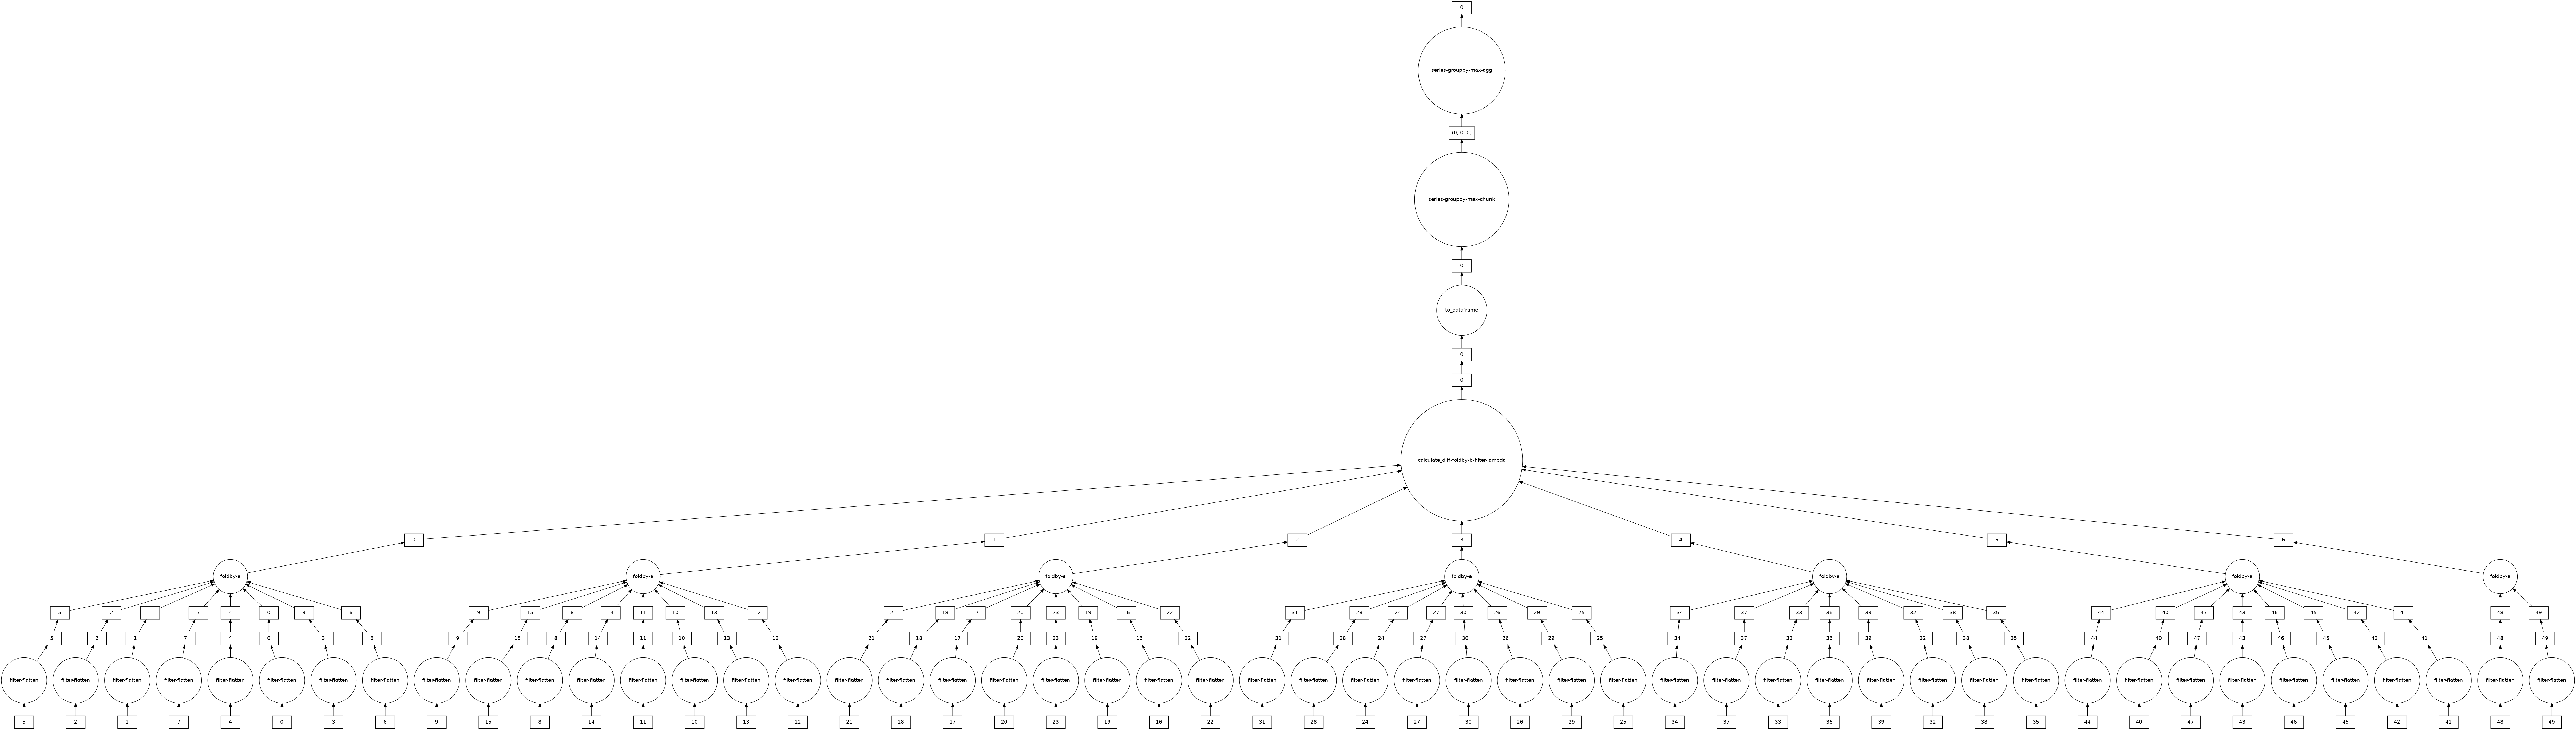

In [36]:
#tiny
daskdf[0].visualize()

In [43]:
#small
daskdf[0].visualize()

In [52]:
#all
daskdf[0].visualize()